![title](../NAG_logo.png)

# Nonlinear data-fitting exercise

 1. Run the notebook and make sure you understand how outliers are affecting the fitted model
 2. In order to provide a _more_ usefull fitted model, there are a variety of strategies, you can try:
 
    * Remove the outliers (pro/cons?)

    * Experiment with more robust fitting techniques that avoid removing outliers. Replace 
    `handle_solve_bxnl` with the more robust `handle_solve_nldf` (see documentation) and try with 
    different loss-functions and regularizations
    
 3. Describe your findings
 

### Installing the NAG library and running this notebook

This notebook depends on the NAG library for Python to run. Please read the instructions in the [Readme.md](https://github.com/numericalalgorithmsgroup/NAGPythonExamples/blob/master/local_optimization/Readme.md#install) file to download, install and obtain a licence for the library.

Instruction on how to run the notebook can be found [here](https://github.com/numericalalgorithmsgroup/NAGPythonExamples/blob/master/local_optimization/Readme.md#jupyter).

# Dealing with outliers in a calibration problem with the NAG optimisation suite

### Correct Rendering of this notebook

This notebook makes use of the `latex_envs` Jupyter extension for equations and references.  If the LaTeX is not rendering properly in your local installation of Jupyter , it may be because you have not installed this extension.  Details at https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html

The notebook is also not rendered well by GitHub so if you are reading it from there, you may prefer the [pdf version instead](./static/portfolio_optimization_qcqp.pdf).

## Calibration problem

Consider a simple calibration problem where we want to fit the 5 parameters of a model $f$ to some given data points. The model is of the form:
$$
\min_{x\in\mathbb{R}^5} \sum_{i=1}^{30}\left( f(t_i, x) - y_i \right)^2
$$
where $x=[a,b,c,d,\omega]$ are the parameters to fit and $f(t, x) = at^2 + bt+ c + d\sin(\omega t)$ is the model.

### Data

The initial data points $\{(t_i, y_i)\}$ were simulated using 
$$(a=0.3,b=1.0,c=0.01,d=0.2,\omega =5.0)$$
with $t_i$ uniformly spread in $\left[-1.0,1.0\right]$ and $y_i=f(t_i,x)+\epsilon_i$ where $\epsilon_i$ is random noise.

Two of those points ($y_{10}$ and $y_{20}$) were modified to emulate the presence of outilers.

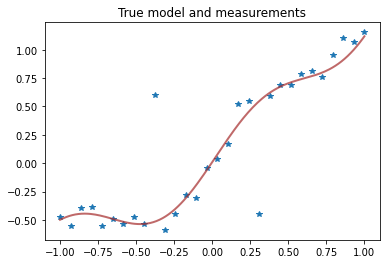

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math

# load the simulated data containing 2 outliers
data = pickle.load(open('nlnlsq_data.pck', 'rb'))
nres = len(data['y'])

# plot the data points and the true function used to generate them
f_true = lambda t : 0.3*t**2 + t + 0.01 + 0.2*math.sin(5.0*t)  
plt.plot(data['t'], data['y'], '*')
t = np.linspace(-1.0,1.0, num=200)
y = [f_true(x) for x in t]
plt.plot(t, y, color='brown', linewidth=2, alpha=0.7)
plt.title('True model and measurements')
plt.show()

### Set up the calibration problem

Start by defining the callbacks that will be used by the solver to determine the quality of the fit with any given set of parameters $x$.

In [2]:
def lsqfun(x, nres, inform, data):
    """
    Objective function callback passed to the least squares solver.
    """
    rx = np.zeros(nres)
    t = data['t']
    y = data['y']
    for i in range(nres):
        rx[i] = (
            x[0]*t[i]**2 + x[1]*t[i] + x[2] + x[3]*np.sin(x[4]*t[i]) - y[i]
            )
    return rx, inform

In [3]:
def lsqgrd(x, nres, rdx, inform, data):
    """
    Computes the Jacobian of the least square residuals.
    """
    n = len(x)
    t = data['t']
    for i in range(nres):
        rdx[i*n+0] = t[i]**2
        rdx[i*n+1] = t[i]
        rdx[i*n+2] = 1.0
        rdx[i*n+3] = np.sin(x[4]*t[i])
        rdx[i*n+4] = x[3]*t[i]*np.cos(x[4]*t[i])
    return inform

Initialize the NAG 'handle' with the problem dimensions and some optional parameters.

In [4]:
from naginterfaces.library import opt
from naginterfaces.base import utils

nvar = 5
# Initialize the Optimization model handle with the number of variables
handle = opt.handle_init(nvar)

# Define a dense nonlinear least-squares objective function
opt.handle_set_nlnls(handle, nres)

# Set some optional parameters to control the output of the solver
for option in [
        'Print Options = NO',
        'Print Level = 1',
        'Print Solution = X',
        'Bxnl Iteration Limit = 100',
]:
    opt.handle_opt_set(handle, option)
    
# Use an explicit I/O manager for abbreviated iteration output:
iom = utils.FileObjManager(locus_in_output=False)

## 1) Solve the problem with outliers

In [5]:
# Call the solver
x = np.ones(nvar, dtype=float)
res = opt.handle_solve_bxnl(handle, lsqfun, lsqgrd, x, nres, data=data,
                  io_manager=iom)

 E04GG, Nonlinear least squares method for bound-constrained problems
 Status: converged, an optimal solution was found
 Value of the objective             1.05037E+00
 Norm of gradient                   8.78014E-06
 Norm of scaled gradient            6.05781E-06
 Norm of step                       1.47886E-01

 Primal variables:
   idx   Lower bound       Value       Upper bound
     1       -inf        3.61301E-01        inf
     2       -inf        9.10227E-01        inf
     3       -inf        3.42138E-03        inf
     4       -inf       -6.08965E+00        inf
     5       -inf        6.24881E-04        inf


We can plot the model with the fitted parameters and see the influence of outliers:

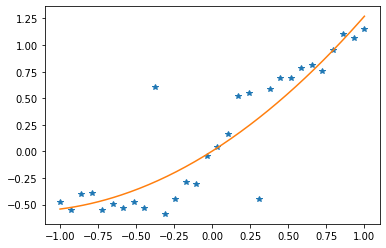

In [6]:
# plot the data points and the fitted function
x = res.x
f_out = lambda t : x[0]*t**2 + x[1]*t + x[2] + x[3]*math.sin(x[4]*t)  
plt.plot(data['t'], data['y'], '*')
y = [f_out(z) for z in t]
plt.plot(t, y)
plt.savefig("outlier_fit.png")
plt.show()

### Remove the outliers and solve again

In [7]:
# Disable the two outlier residuals
opt.handle_disable(handle, comp='NLS', idx=[10, 20])

# Solve the problem again
x = np.ones(nvar, dtype=float)
res = opt.handle_solve_bxnl(handle, lsqfun, lsqgrd, x, nres, data=data,
                      io_manager=iom)

 E04GG, Nonlinear least squares method for bound-constrained problems
 Status: converged, an optimal solution was found
 Value of the objective             5.96811E-02
 Norm of gradient                   1.19914E-06
 Norm of scaled gradient            3.47087E-06
 Norm of step                       3.49256E-06

 Primal variables:
   idx   Lower bound       Value       Upper bound
     1       -inf        3.53888E-01        inf
     2       -inf        1.06575E+00        inf
     3       -inf        1.91383E-03        inf
     4       -inf        2.17299E-01        inf
     5       -inf        5.17660E+00        inf


The fitted function is much closer to the data!

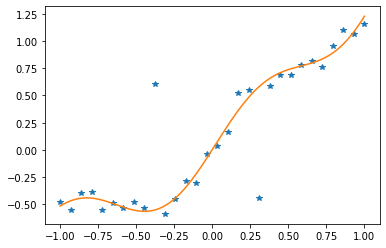

In [8]:
# plot the data points and the fitted function
x = res.x
f_fit = lambda t : x[0]*t**2 + x[1]*t + x[2] + x[3]*math.sin(x[4]*t)  
plt.plot(data['t'], data['y'], '*')
y = [f_fit(z) for z in t]
plt.plot(t, y)
plt.show()

In [9]:
# Free the handle after experimenting
# opt.handle_free(handle)

## 2) Replace `handle_solve_bxnl` with the more robust `handle_solve_nldf`
(see documentation: `?opt.handle_solve_nldf`) and try different loss-functions and regularizations.

What is the main difference between BXNL and NLDF?

In [10]:
?opt.handle_solve_nldf

## 3) Describe your findings